In [1]:
import numpy as np
import scipy.optimize
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from gca import gc_block_covariance, gca_obj_v, gca_obj_w, unit_norm

## Set random number generation seed

In [2]:
np.random.seed(0)

## Generate VAR process

In [3]:
L=3 # VAR model order
P=2 # number of pairs that we will ask GCA to compute
K=3 # number of latent sources
D=4 # number of sensors
N=5000 # number of time points
sigma_inn=1 # standard deviation of innovation process
sigma_sensor=0.01 # standard deviation of additive noise

## Define VAR matrix of latent sources
- We have s1-->s2 and s2-->s3

In [4]:
r1=0.9
theta1=40/120*2*np.pi
r2=0.7
theta2=10/120*2*np.pi
r3=0.8
theta3=50/120*2*np.pi

B = np.zeros(shape=(K,K,L))

#create the VAR system matrix here
B[:,:,0] = [ [2*r1*np.cos(theta1), 0, 0], [-0.356, 2*r2*np.cos(theta2), 0], [0, -0.3098, 2*r3*np.cos(theta3)] ]
B[:,:,1]= [ [-r1**2, 0, 0], [0.7136, -r2**2, 0], [0, 0.5, -r3**2] ]
B[:,:,2] = [ [0, 0, 0], [-0.356, 0, 0], [0, -0.3098, 0] ]

## Generate the dynamics of the latent sources

In [5]:
S = np.zeros(shape=(K,N))
S[:,0:L] = np.random.randn(K,L)
for n in range(L,N):
    for p in range(0,L):
        S[:,n]=B[:,:,p] @ S[:,n-p]
    S[:,n]+=sigma_inn*np.random.randn(K,)

## Simulate the observations

In [6]:
A = np.random.rand(D,K)
X = A@S + sigma_sensor*np.random.randn(D,N)

## Center the data in X

In [7]:
X = X - np.tile( np.mean(X, axis=1) , (N,1) ).T

## Standardize the data in X

In [8]:
X = X / np.tile( np.std(X, axis=1) , (N,1) ).T

## Form a copy of X but with time reversed

In [9]:
Xr = np.fliplr(X)

## Transpose to (samples, channels)

In [10]:
X = X.T
Xr = Xr.T
X.shape, Xr.shape

((5000, 4), (5000, 4))

## Run the GCA algorithm

In [11]:
results = {'data': X} # initialize results dictionary

n_pairs = 2
max_iters = 300
opt_tol = 1e-6
method="trust-constr"

# initialize v and w
vo = 0.01 * np.random.randn(D,)
wo = 0.01 * np.random.randn(D,)

for p in range(1,n_pairs+1):

    v = vo.copy()
    w = wo.copy()

    blkR1, Rtilde = gc_block_covariance(X,L) # forward time
    blkR1r, Rtilder = gc_block_covariance(Xr,L) # reverse time

    fval_v_last = np.inf
    fval_w_last = np.inf

    for iter in range(max_iters):

            print(p, iter)

            optres_v = minimize(gca_obj_v, vo, args=( (w, blkR1, Rtilde, blkR1r, Rtilder) ) , constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 0, 0)], method=method, tol = 1e-6)

            v = optres_v.x
            fval_v = optres_v.fun
            del_fval_v = np.abs(fval_v_last - fval_v)
            fval_v_last = fval_v

            optres_w = minimize(gca_obj_w, wo, args=( (v, blkR1, Rtilde, blkR1r, Rtilder) ) , constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 0, 0)], method=method, tol=1e-6)

            w = optres_w.x
            fval_w = optres_w.fun
            del_fval_w = np.abs(fval_w_last - fval_w)
            fval_w_last = fval_w

            if del_fval_v < opt_tol and del_fval_w < opt_tol:
                print(f"Converged in {iter} iterations")
                break

    if iter == max_iters-1:
        print(f"Warning: did not converge in {max_iters} iterations")

    # compute the driven and driving signals
    y_hat = X@w
    z_hat = X@v

    # driven and driving signals with the original data
    y_hat_og = results['data']@w
    z_hat_og = results['data']@v

    # form a convolution matrix from y_hat
    convmat = scipy.linalg.convolution_matrix(y_hat, L, mode='full')[0:-L+1,:]

    # add a column of ones to convmat
    convmat = np.concatenate((convmat, np.ones((convmat.shape[0],1))), axis=1)

    # regress out y_hat from x
    X = X - convmat@np.linalg.pinv(convmat)@X
    Xr = np.flipud(X)

    # store results
    results[p] = {'v': v, 'w': w,
                  'y_hat': y_hat, 'z_hat': z_hat,
                  'y_hat_og': y_hat_og, 'z_hat_og': z_hat_og,
                  'optres_v': optres_v, 'optres_w': optres_w}


1 0


/Users/jacekdmochowski/miniconda3/envs/james_tf/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


1 1
1 2
1 3
1 4
1 5
1 6
Converged in 6 iterations
2 0
2 1
2 2
2 3
Converged in 3 iterations


## Display the original and recovered sources

Text(0.5, 1.0, 'z2 vs. s3')

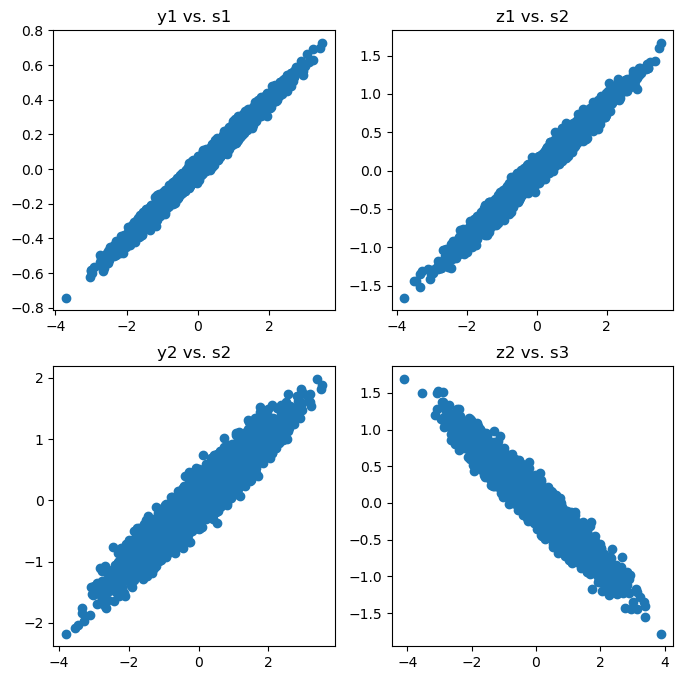

In [13]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].scatter(S[0,:],results[1]['y_hat_og'])
ax[0,0].set_title("y1 vs. s1")
ax[0,1].scatter(S[1,:],results[1]['z_hat_og'])
ax[0,1].set_title("z1 vs. s2")
ax[1,0].scatter(S[1,:],results[2]['y_hat_og'])
ax[1,0].set_title("y2 vs. s2")
ax[1,1].scatter(S[2,:],results[2]['z_hat_og'])
ax[1,1].set_title("z2 vs. s3")
